In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20

Dataset URL: https://www.kaggle.com/datasets/joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
mpox-skin-lesion-dataset-version-20-msld-v20.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/mpox-skin-lesion-dataset-version-20-msld-v20.zip','r')
zip_ref.extractall ('/content')
zip_ref.close()

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/HAM10000.zip','r')
dataset_dir= zip_ref.extractall ('/content')
zip_ref.close()

In [ ]:
#Importing all the required libraries
import pandas as pd
#for Math operations
import numpy as np
#Machine learning libraries
import os
from random import shuffle
from shutil import copyfile
import random
#for opening and loading images
!pip install opencv-python
import cv2
# for Preprocessing
from tensorflow.keras.preprocessing import image
#for visualization
import plotly.express as px
import matplotlib.pyplot as plt
#convert class labels to one-hot encoded vectors
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from keras.optimizers import Adam

from numpy import loadtxt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


In [ ]:
train_folder = "/content/Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train"
val_folder = "/content/Original Images/Original Images/FOLDS/fold5/Valid"
test_folder = "/content/Original Images/Original Images/FOLDS/fold5/Test"

In [ ]:
BATCH_SIZE = 16
train_gen = ImageDataGenerator(rescale=1./255)  # Normalization done to rescale the pixel values of the images to a range of [0, 1] by dividing by 255
train_data = train_gen.flow_from_directory(directory=train_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42)

val_gen = ImageDataGenerator(rescale=1./255)
val_data = val_gen.flow_from_directory(directory=val_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42)

test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(directory=test_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, seed = 42)
train_data.class_indices

Found 7532 images belonging to 6 classes.
Found 154 images belonging to 6 classes.
Found 63 images belonging to 6 classes.


{'Chickenpox': 0,
 'Cowpox': 1,
 'HFMD': 2,
 'Healthy': 3,
 'Measles': 4,
 'Monkeypox': 5}

In [ ]:
x,y = next(train_data)
x.shape

(16, 224, 224, 3)

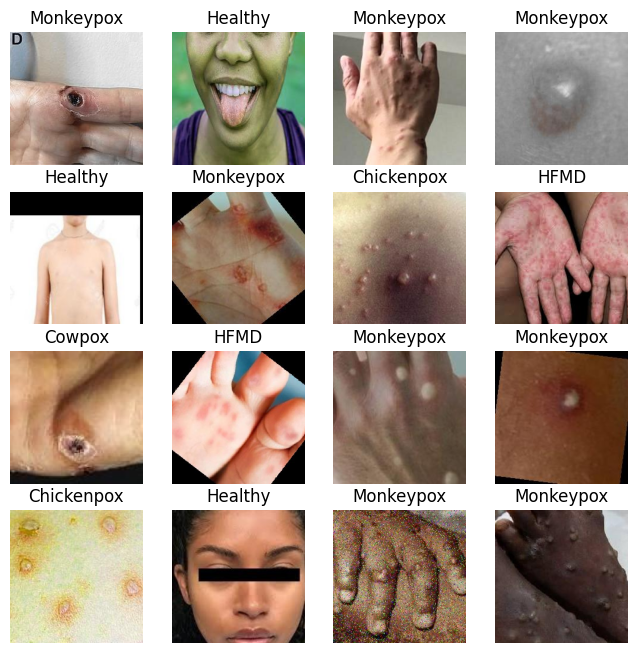

In [ ]:
# OR we can display simply by
a = train_data.class_indices
class_names = list(a.keys())  # storing class/breed names in a list


def plot_images(img, labels):
    plt.figure(figsize=[8, 10])
    for i in range(len(img)):
        plt.subplot(5, 4, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()
plot_images(x,y)

In [ ]:
# def class_distrubution(folder):
#   # Calculate class distribution
#   class_names = os.listdir(folder)
#   class_dis = [len(os.listdir(folder + "/" + name)) for name in class_names]
#   fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
#   fig.update_layout(title_x = 0.47)
#   fig.show()



In [ ]:
# class_distrubution(train_folder)
# #class_distrubution(val_folder)

Applying **SMOTE** to Monkeypox dataset

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from collections import Counter
import matplotlib.pyplot as plt

# Load and preprocess the entire dataset
def load_and_preprocess_images(image_paths, target_size):
    images = []
    for filepath in image_paths:
        image = cv2.imread(filepath)
        image = cv2.resize(image, target_size)
        image = image / 255.0  # Normalize image
        images.append(image)
    return np.array(images, dtype=np.float32)  # Convert to float32

train_image_paths = train_data.filepaths
train_labels = train_data.classes

# Assuming train_image_paths and train_labels are available
target_size = (224, 224)
X = load_and_preprocess_images(train_image_paths, target_size)
y = np.array(train_labels)

# Flatten images for SMOTE
X_flat = X.reshape(X.shape[0], -1)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled_flat, y_resampled = smote.fit_resample(X_flat, y)

# Reshape back to image format
X_resampled = X_resampled_flat.reshape(-1, *target_size, 3)

# One-hot encode labels
y_resampled_one_hot = to_categorical(y_resampled, num_classes=len(np.unique(y)))

# Print the resampled class distribution
print("Resampled class distribution:", Counter(y_resampled))


Resampled class distribution: Counter({0: 2968, 1: 2968, 2: 2968, 3: 2968, 4: 2968, 5: 2968})


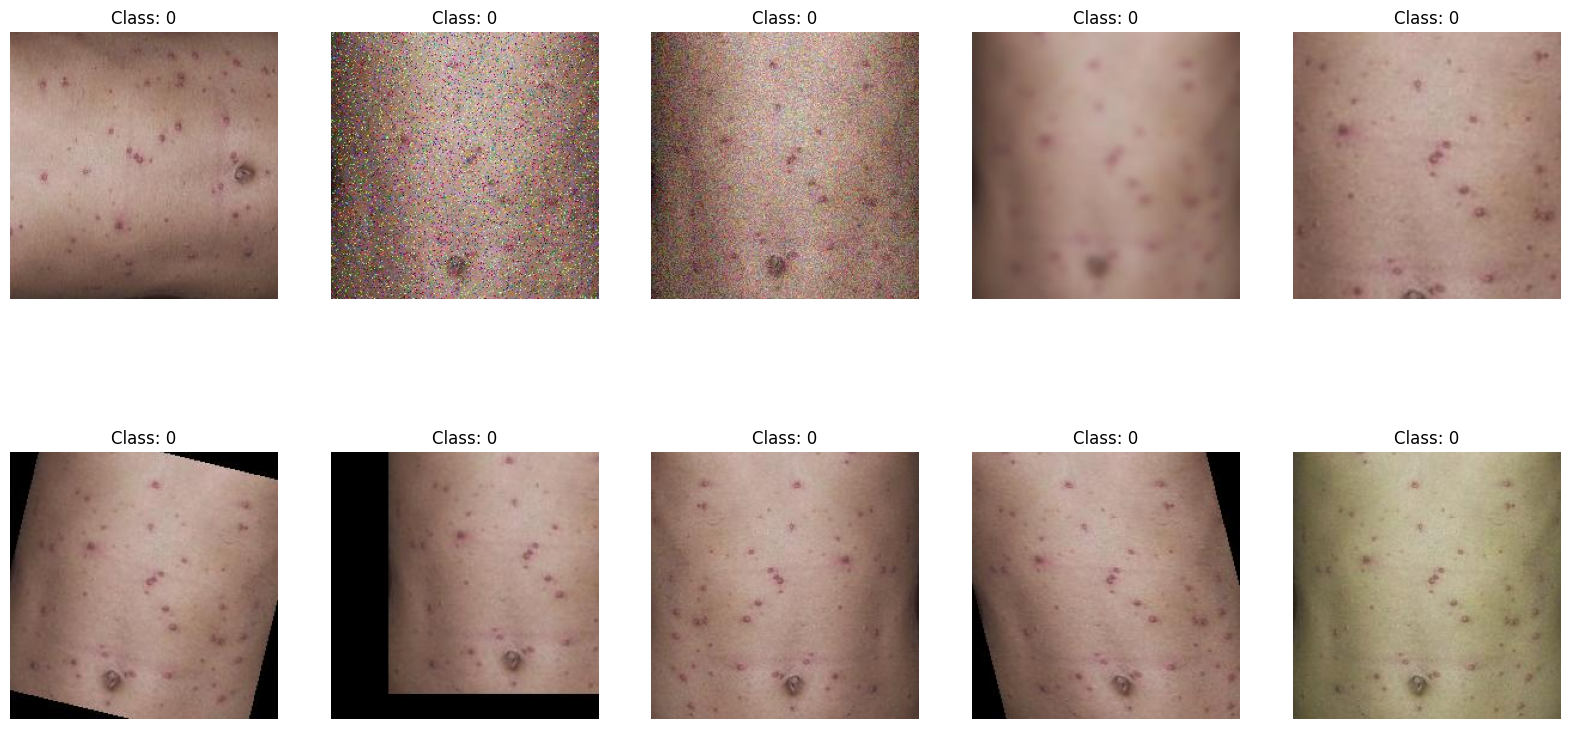

In [ ]:
class BalancedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

    def visualize_data(self, X, y, num_samples=10):
        plt.figure(figsize=(20, 10))
        for i in range(num_samples):
            ax = plt.subplot(2, num_samples // 2, i + 1)
            img = cv2.cvtColor((X[i] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)  # Convert back to uint8
            plt.imshow(img)
            plt.title(f"Class: {np.argmax(y[i])}")
            plt.axis("off")
        plt.show()

# Create an instance of the data generator
batch_size = 32
resampled_datagen = BalancedDataGenerator(X_resampled, y_resampled_one_hot, batch_size)

# Visualize some resampled data
X_batch, y_batch = resampled_datagen.__getitem__(0)
resampled_datagen.visualize_data(X_batch, y_batch, num_samples=10)


In [ ]:

# # Define paths to HAM10000 dataset
# dataset_dir = '/content/drive/MyDrive/Colab Notebooks/HAM1000'
# ham_part1 = os.path.join(dataset_dir, '/content/ham10000_images_part_1')
# ham_part2 = os.path.join(dataset_dir, '/content/ham10000_images_part_2')
# metadata_path = os.path.join(dataset_dir, '/content/HAM10000_metadata.csv')
# output_dir = '/content/drive/MyDrive/Colab Notebooks/HAM10000'

# # Load metadata
# metadata = pd.read_csv(metadata_path)

# class_mapping = {
#     'akiec': 'class1',
#     'bcc': 'class2',
#     'bkl': 'class3',
#     'df': 'class4',
#     'mel': 'class5',
#     'nv': 'class6',
#     'vasc': 'class7'
# }


In [ ]:
# # Create directories
# for split in ['train', 'validation', 'test']:
#     for class_name in class_mapping.values():
#         os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# # Split metadata into training, validation, and test sets
# train_val_df, test_df = train_test_split(metadata, test_size=0.2, stratify=metadata['dx'], random_state=42)
# train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['dx'], random_state=42)

# # Helper function to copy images to corresponding directories
# def copy_images(df, split):
#     for _, row in df.iterrows():
#         img_name = row['image_id'] + '.jpg'
#         if os.path.exists(os.path.join(ham_part1, img_name)):
#             src_path = os.path.join(ham_part1, img_name)
#         else:
#             src_path = os.path.join(ham_part2, img_name)
#         dst_dir = os.path.join(output_dir, split, class_mapping[row['dx']])
#         copyfile(src_path, os.path.join(dst_dir, img_name))

# # Copy images to respective directories
# copy_images(train_df, 'train')
# copy_images(val_df, 'validation')
# copy_images(test_df, 'test')

# print("Dataset organized successfully.")

In [ ]:
# Define paths
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/HAM10000'

# Define ImageDataGenerators
ham_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

ham_val_datagen = ImageDataGenerator(rescale=1./255)

ham_test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
ham_train_generator = ham_train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

ham_val_generator = ham_val_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

ham_test_generator = ham_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 6009 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.


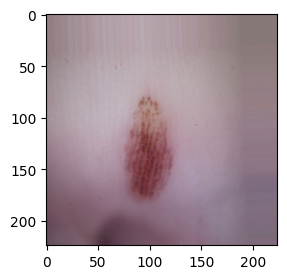

In [ ]:
plt.figure(figsize=(3,3))
plt.imshow(ham_train_generator[0][0][0])

# Building the Model

## Model 1 : ResNet50

In [ ]:
# # Create TensorFlow datasets from ImageDataGenerators(to be continused from above where we created train_data, val_data, test_data from flow_from_directory command)
# train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, train_data.num_classes]))
# val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, val_data.num_classes]))
# test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, test_data.num_classes]))

# # Apply prefetch and autotune
# train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Callbacks are used to perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).
# In our case, we are using Modelcheckpoint for saving the model weights into the disk for a minimum value of validation loss. Further,
# we are also using ReduceLROnPlateau for reducing the learning rate of the model by a factor of 0.5 if its validation loss doesn’t improve for 3 consecutive epochs.

checkpoint = ModelCheckpoint('.mdl1_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
callbacks = [checkpoint,reduce_lr, early_stopping]

In [ ]:
# Load the ResNet50 model pretrained on ImageNet data and use fine tuning

conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 5s 0us/step


Pre-train on HAM10000 dataset

In [ ]:
# Number of classes in HAM10000
num_classes_ham = 7

# Freeze base model layers
for layer in conv_base.layers:
    layer.trainable = False

# Add custom layers for HAM10000
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes_ham, activation='softmax')(x)

model_ham = Model(inputs=conv_base.input, outputs=predictions)

# Compile the model
model_ham.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ["accuracy"])

# Train the model
history = model_ham.fit(
    ham_train_generator, batch_size=BATCH_SIZE,
    validation_data=ham_val_generator, verbose=1,
    epochs=10
)

Epoch 1/10
188/188 [==============================] - 6172s 33s/step - loss: 1.1582 - accuracy: 0.6628 - val_loss: 1.1274 - val_accuracy: 0.6695
Epoch 2/10
188/188 [==============================] - 129s 688ms/step - loss: 1.1354 - accuracy: 0.6695 - val_loss: 1.1413 - val_accuracy: 0.6695
Epoch 3/10
188/188 [==============================] - 129s 685ms/step - loss: 1.1311 - accuracy: 0.6693 - val_loss: 1.1358 - val_accuracy: 0.6695
Epoch 4/10
188/188 [==============================] - 128s 683ms/step - loss: 1.1283 - accuracy: 0.6698 - val_loss: 1.1183 - val_accuracy: 0.6695
Epoch 5/10
188/188 [==============================] - 130s 691ms/step - loss: 1.1190 - accuracy: 0.6693 - val_loss: 1.1082 - val_accuracy: 0.6695
Epoch 6/10
188/188 [==============================] - 128s 679ms/step - loss: 1.1135 - accuracy: 0.6692 - val_loss: 1.1251 - val_accuracy: 0.6705
Epoch 7/10
188/188 [==============================] - 129s 684ms/step - loss: 1.1109 - accuracy: 0.6697 - val_loss: 1.1210 - 

Modify the Model for Monkeypox

In [ ]:

# Number of classes in the Monkeypox dataset
num_classes_mpox = 6

# Remove the last layer (HAM10000 classifier)
model_ham.layers.pop()

# Add a new dense layer for the Monkeypox dataset
x = model_ham.layers[-1].output
predictions = Dense(num_classes_mpox, activation='softmax')(x)

model_mpox = Model(inputs=model_ham.input, outputs=predictions)

Fine-tune on Monkepypox dataset

In [ ]:
# Unfreeze some top layers for fine-tuning
for layer in conv_base.layers[:]:
    layer.trainable = True

# Re-compile model with a lower learning rate
model_mpox.compile(optimizer = Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics = ["accuracy"])

#
history = model_mpox.fit(
    resampled_datagen,
    validation_data=val_data,
    batch_size = BATCH_SIZE,
    epochs=30,verbose=1, callbacks=callbacks
)

Epoch 1/30
557/557 [==============================] - ETA: 0s - loss: 1.7896 - accuracy: 0.1570
Epoch 1: val_accuracy improved from -inf to 0.09740, saving model to .mdl1_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


557/557 [==============================] - 48s 71ms/step - loss: 1.7896 - accuracy: 0.1570 - val_loss: 1.8382 - val_accuracy: 0.0974 - lr: 1.0000e-05
Epoch 2/30
557/557 [==============================] - ETA: 0s - loss: 1.7385 - accuracy: 0.2258
Epoch 2: val_accuracy did not improve from 0.09740
557/557 [==============================] - 35s 63ms/step - loss: 1.7385 - accuracy: 0.2258 - val_loss: 1.8506 - val_accuracy: 0.0974 - lr: 1.0000e-05
Epoch 3/30
557/557 [==============================] - ETA: 0s - loss: 1.7069 - accuracy: 0.2499
Epoch 3: val_accuracy did not improve from 0.09740
557/557 [==============================] - 35s 62ms/step - loss: 1.7069 - accuracy: 0.2499 - val_loss: 1.8442 - val_accuracy: 0.0974 - lr: 1.0000e-05
Epoch 4/30
557/557 [==============================] - ETA: 0s - loss: 1.6929 - accuracy: 0.2523
Epoch 4: val_accuracy did not improve from 0.09740
557/557 [==============================] - 35s 63ms/step - loss: 1.6929 - accuracy: 0.2523 - val_loss: 1.8303

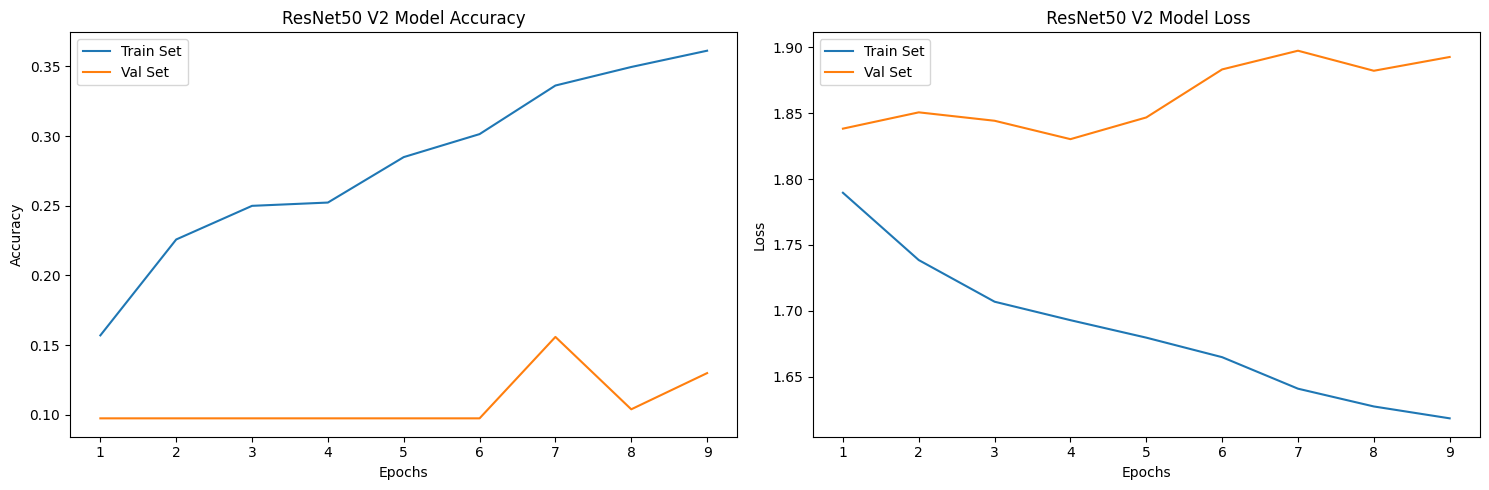

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50 V2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' ResNet50 V2 Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl1_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 2s 29ms/step - loss: 1.8974 - accuracy: 0.1558
[1.8973661661148071, 0.15584415197372437]


model performed moderately well on test data with an overall validation accuracy of ---%. But now we will evaluate it on completely unseen test data so that we can assess its performance in a real sense

In [ ]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 1s 268ms/step - loss: 1.8535 - accuracy: 0.1429

 Test_Accuracy:- 0.1428571492433548


Confusion Matrix

4/4 [==============================] - 1s 28ms/step
              precision    recall  f1-score   support

           0       0.08      0.43      0.14         7
           1       0.00      0.00      0.00         7
           2       0.22      0.40      0.29        15
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00        18

    accuracy                           0.14        63
   macro avg       0.05      0.14      0.07        63
weighted avg       0.06      0.14      0.08        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


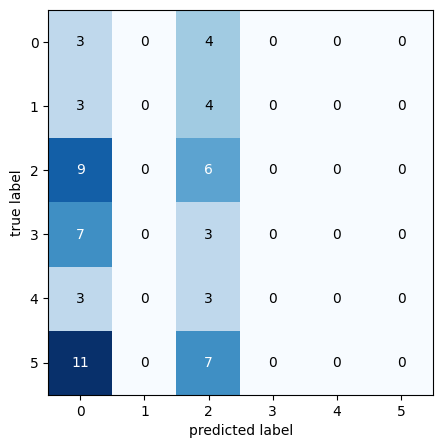

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("ResNet50-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

ResNet50-based Model Accuracy: 14.29%
Precision: 0.051
Recall: 0.138
F1 Score: 0.071


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model 2: MobileNet V2



In [ ]:
checkpoint = ModelCheckpoint('.mdl2_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
callbacks = [checkpoint,reduce_lr, early_stopping]

In [ ]:
conv_base = MobileNetV2(
    include_top=False,
    weights='imagenet')

# Number of classes in HAM10000
num_classes_ham = 7

# Freeze base model layers
for layer in conv_base.layers:
    layer.trainable = False

x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(num_classes_ham, activation='softmax')(x)
model_ham = Model(conv_base.input, predictions)

# Compile the model
model_ham.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ["accuracy"])

# Train the model
history = model_ham.fit(
    ham_train_generator, batch_size=BATCH_SIZE,
    validation_data=ham_val_generator, verbose=1,
    epochs=10
)

9406464/9406464 [==============================] - 2s 0us/step
Epoch 1/10
188/188 [==============================] - 133s 678ms/step - loss: 2.7672 - accuracy: 0.1626 - val_loss: 1.7915 - val_accuracy: 0.3125
Epoch 2/10
188/188 [==============================] - 128s 679ms/step - loss: 2.4360 - accuracy: 0.2328 - val_loss: 1.6870 - val_accuracy: 0.4204
Epoch 3/10
188/188 [==============================] - 129s 685ms/step - loss: 2.1915 - accuracy: 0.2894 - val_loss: 1.6115 - val_accuracy: 0.4873
Epoch 4/10
188/188 [==============================] - 128s 680ms/step - loss: 2.0084 - accuracy: 0.3275 - val_loss: 1.5098 - val_accuracy: 0.5392
Epoch 5/10
188/188 [==============================] - 127s 677ms/step - loss: 1.8455 - accuracy: 0.3916 - val_loss: 1.3670 - val_accuracy: 0.5871
Epoch 6/10
188/188 [==============================] - 128s 679ms/step - loss: 1.7388 - accuracy: 0.4205 - val_loss: 1.2774 - val_accuracy: 0.6191
Epoch 7/10
188/188 [==============================] - 127s 67

In [ ]:
# Number of classes in the Monkeypox dataset
num_classes_mpox = 6

# Remove the last layer (HAM10000 classifier)
model_ham.layers.pop()

# Add a new dense layer for the Monkeypox dataset
x = model_ham.layers[-1].output
predictions = Dense(num_classes_mpox, activation='softmax')(x)

model_mpox = Model(inputs=model_ham.input, outputs=predictions)

In [ ]:
# Unfreeze some layers in the base model

for layer in conv_base.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False
for layer in conv_base.layers[100:]:  # Unfreeze the rest
    layer.trainable = True
# Re-compile model with a lower learning rate
model_mpox.compile(optimizer = Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics = ["accuracy"])


history = model_mpox.fit(
    resampled_datagen,
    validation_data=val_data,
    batch_size = BATCH_SIZE,
    epochs=30,verbose=1, callbacks=callbacks
)

Epoch 1/30
556/557 [============================>.] - ETA: 0s - loss: 1.8035 - accuracy: 0.1697
Epoch 1: val_accuracy improved from -inf to 0.12338, saving model to .mdl2_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


557/557 [==============================] - 36s 42ms/step - loss: 1.8038 - accuracy: 0.1695 - val_loss: 1.8306 - val_accuracy: 0.1234 - lr: 1.0000e-05
Epoch 2/30
556/557 [============================>.] - ETA: 0s - loss: 1.8024 - accuracy: 0.1685
Epoch 2: val_accuracy did not improve from 0.12338
557/557 [==============================] - 21s 37ms/step - loss: 1.8027 - accuracy: 0.1683 - val_loss: 1.8382 - val_accuracy: 0.0909 - lr: 1.0000e-05
Epoch 3/30
557/557 [==============================] - ETA: 0s - loss: 1.8022 - accuracy: 0.1687
Epoch 3: val_accuracy did not improve from 0.12338

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
557/557 [==============================] - 20s 36ms/step - loss: 1.8022 - accuracy: 0.1687 - val_loss: 1.8428 - val_accuracy: 0.0974 - lr: 1.0000e-05
Epoch 4/30
557/557 [==============================] - ETA: 0s - loss: 1.8003 - accuracy: 0.1790
Epoch 4: val_accuracy did not improve from 0.12338
557/557 [=======================

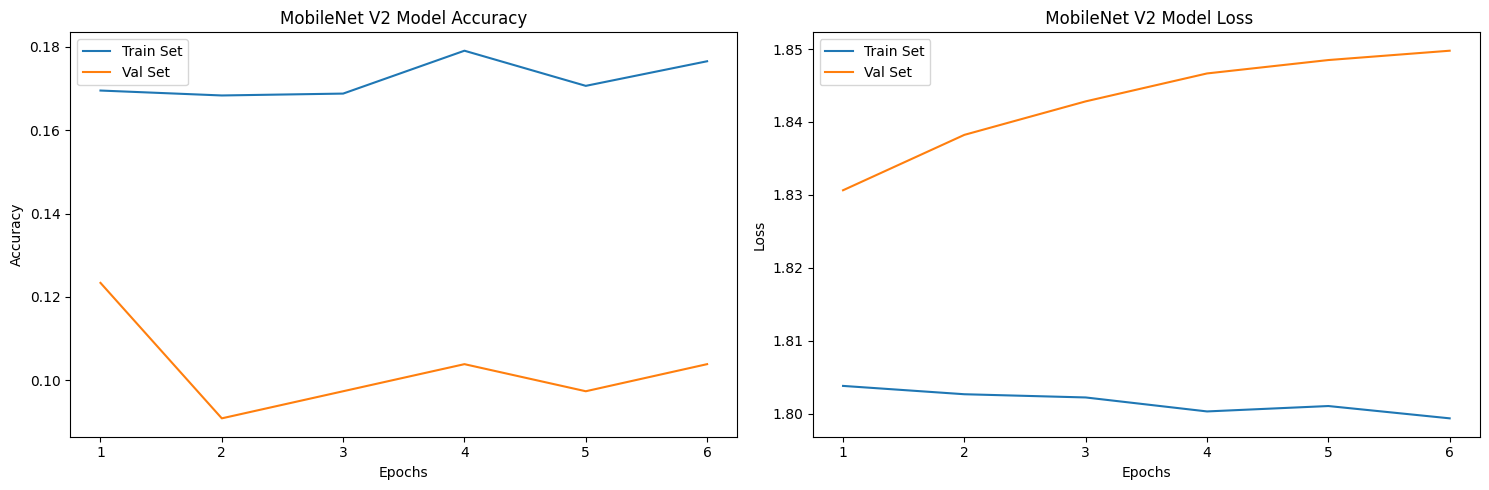

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNet V2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' MobileNet V2 Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl2_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 1s 28ms/step - loss: 1.8306 - accuracy: 0.1234
[1.8306361436843872, 0.12337662279605865]


In [ ]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 0s 44ms/step - loss: 1.8242 - accuracy: 0.1587

 Test_Accuracy:- 0.1587301641702652


4/4 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.14      0.71      0.24         7
           1       0.20      0.14      0.17         7
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        10
           4       0.19      0.67      0.30         6
           5       0.00      0.00      0.00        18

    accuracy                           0.16        63
   macro avg       0.09      0.25      0.12        63
weighted avg       0.06      0.16      0.07        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


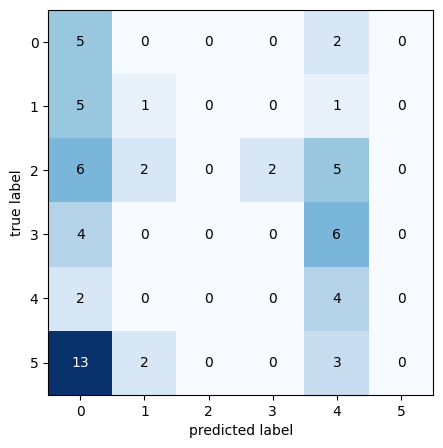

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("MobileNet-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

MobileNet-based Model Accuracy: 15.87%
Precision: 0.089
Recall: 0.254
F1 Score: 0.117


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 3 : DenseNet121


In [ ]:
checkpoint = ModelCheckpoint('.mdl3_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
callbacks = [checkpoint,reduce_lr, early_stopping]

In [ ]:
from tensorflow.keras.applications import DenseNet121

# Load the DenseNet121 model pretrained on ImageNet data
conv_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Number of classes in HAM10000
num_classes_ham = 7

# Freeze base model layers
for layer in conv_base.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes_ham, activation='softmax')(x)
model_ham = Model(inputs=conv_base.input, outputs=predictions)

# Compile the model
model_ham.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ["accuracy"])

# Train the model
history = model_ham.fit(
    ham_train_generator, batch_size=BATCH_SIZE,
    validation_data=ham_val_generator, verbose=1,
    epochs=10
)

29084464/29084464 [==============================] - 2s 0us/step
Epoch 1/10
188/188 [==============================] - 137s 694ms/step - loss: 0.9823 - accuracy: 0.6781 - val_loss: 0.8391 - val_accuracy: 0.6960
Epoch 2/10
188/188 [==============================] - 129s 687ms/step - loss: 0.8164 - accuracy: 0.7044 - val_loss: 0.7786 - val_accuracy: 0.7109
Epoch 3/10
188/188 [==============================] - 128s 682ms/step - loss: 0.7591 - accuracy: 0.7211 - val_loss: 0.7593 - val_accuracy: 0.7224
Epoch 4/10
188/188 [==============================] - 129s 685ms/step - loss: 0.7356 - accuracy: 0.7314 - val_loss: 0.7598 - val_accuracy: 0.7244
Epoch 5/10
188/188 [==============================] - 128s 682ms/step - loss: 0.7067 - accuracy: 0.7414 - val_loss: 0.7531 - val_accuracy: 0.7154
Epoch 6/10
188/188 [==============================] - 128s 681ms/step - loss: 0.6873 - accuracy: 0.7517 - val_loss: 0.7246 - val_accuracy: 0.7294
Epoch 7/10
188/188 [==============================] - 128s 

In [ ]:
# Number of classes in the Monkeypox dataset
num_classes_mpox = 6

# Remove the last layer (HAM10000 classifier)
model_ham.layers.pop()

# Add a new dense layer for the Monkeypox dataset
x = model_ham.layers[-1].output
predictions = Dense(num_classes_mpox, activation='softmax')(x)

model_mpox = Model(inputs=model_ham.input, outputs=predictions)

In [ ]:
# Unfreeze some layers in the base model

for layer in conv_base.layers[:150]:  # Freeze first 150 layers
    layer.trainable = False
for layer in conv_base.layers[150:]:  # Unfreeze the rest
    layer.trainable = True
# Re-compile model with a lower learning rate
model_mpox.compile(optimizer = Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics = ["accuracy"])


history = model_mpox.fit(
    resampled_datagen,
    validation_data=val_data,
    batch_size = BATCH_SIZE,
    epochs=30,verbose=1, callbacks=callbacks
)

Epoch 1/30
557/557 [==============================] - ETA: 0s - loss: 1.7632 - accuracy: 0.2366
Epoch 1: val_accuracy improved from -inf to 0.21429, saving model to .mdl3_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


557/557 [==============================] - 104s 106ms/step - loss: 1.7632 - accuracy: 0.2366 - val_loss: 1.7410 - val_accuracy: 0.2143 - lr: 1.0000e-05
Epoch 2/30
557/557 [==============================] - ETA: 0s - loss: 1.6600 - accuracy: 0.3655
Epoch 2: val_accuracy did not improve from 0.21429
557/557 [==============================] - 50s 91ms/step - loss: 1.6600 - accuracy: 0.3655 - val_loss: 1.7499 - val_accuracy: 0.1948 - lr: 1.0000e-05
Epoch 3/30
557/557 [==============================] - ETA: 0s - loss: 1.5914 - accuracy: 0.4447
Epoch 3: val_accuracy did not improve from 0.21429

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
557/557 [==============================] - 51s 91ms/step - loss: 1.5914 - accuracy: 0.4447 - val_loss: 1.7656 - val_accuracy: 0.1948 - lr: 1.0000e-05
Epoch 4/30
557/557 [==============================] - ETA: 0s - loss: 1.5416 - accuracy: 0.4916
Epoch 4: val_accuracy did not improve from 0.21429
557/557 [=====================

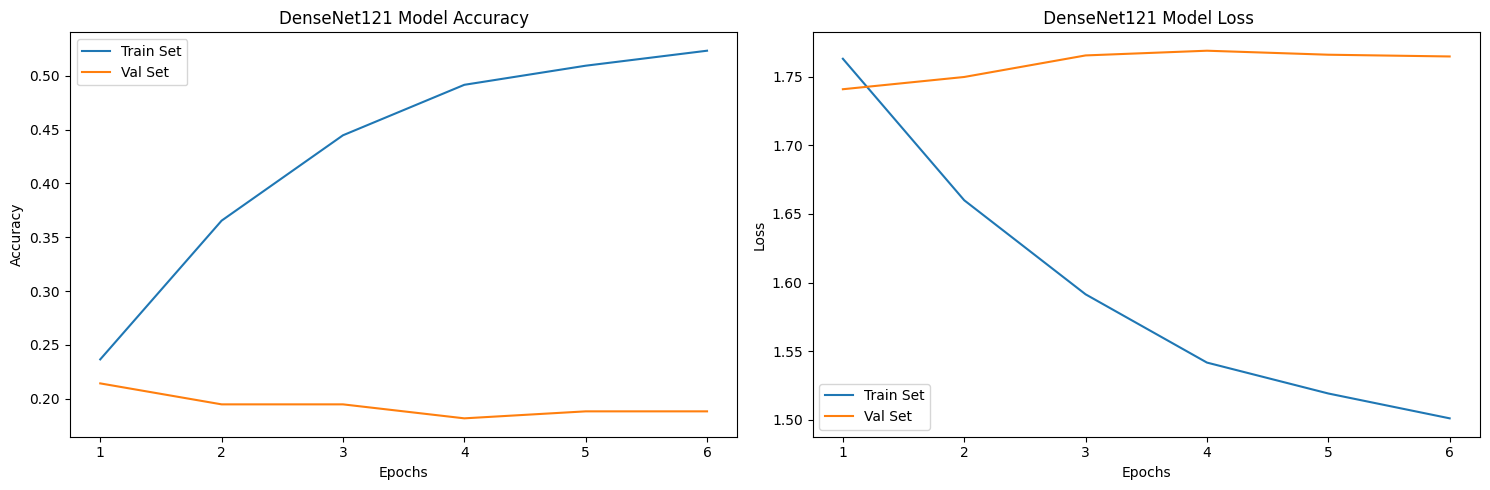

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('DenseNet121 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' DenseNet121 Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl3_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 2s 30ms/step - loss: 1.7410 - accuracy: 0.2143
[1.7409586906433105, 0.2142857164144516]


In [ ]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 0s 103ms/step - loss: 1.7039 - accuracy: 0.2222

 Test_Accuracy:- 0.2222222238779068


4/4 [==============================] - 2s 25ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.40      0.29      0.33         7
           2       0.00      0.00      0.00        15
           3       0.22      0.90      0.35        10
           4       0.09      0.17      0.12         6
           5       0.50      0.11      0.18        18

    accuracy                           0.22        63
   macro avg       0.20      0.24      0.16        63
weighted avg       0.23      0.22      0.16        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


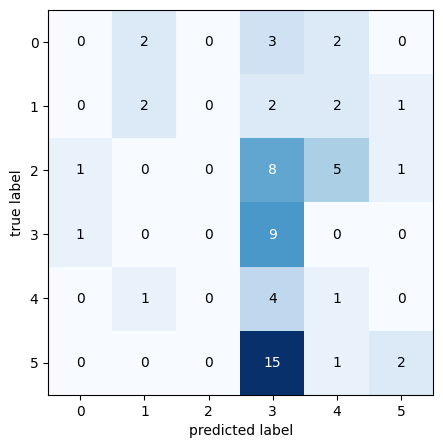

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("DenseNet121-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

DenseNet121-based Model Accuracy: 22.22%
Precision: 0.202
Recall: 0.244
F1 Score: 0.164


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
